In [2]:
# https://python-control.readthedocs.io/en/latest/optimal.html

In [3]:
import numpy as np
import control as ct
import control.optimal as opt
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def vehicle_update(t, x, u, params):
    # Get the parameters for the model
    l = params.get('wheelbase', 3.)         # vehicle wheelbase
    phimax = params.get('maxsteer', 0.5)    # max steering angle (rad)

    # Saturate the steering input
    phi = np.clip(u[1], -phimax, phimax)

    # Return the derivative of the state
    return np.array([
        np.cos(x[2]) * u[0],            # xdot = cos(theta) v
        np.sin(x[2]) * u[0],            # ydot = sin(theta) v
        (u[0] / l) * np.tan(phi)        # thdot = v/l tan(phi)
    ])

def vehicle_output(t, x, u, params):
    return x                            # return x, y, theta (full state)

# Define the vehicle steering dynamics as an input/output system
vehicle = ct.NonlinearIOSystem(
    vehicle_update, vehicle_output, states=3, name='vehicle',
    inputs=('v', 'phi'), outputs=('x', 'y', 'theta'))

In [5]:
# We consider an optimal control problem that consists of “changing lanes” by moving from the 
# point x = 0 m, y = -2 m, \theta = 0 to the point x = 100 m, y = 2 m, \theta = 0) over a 
# period of 10 seconds and with a with a starting and ending velocity of 10 m/s:

x0 = [0., -2., 0.]; u0 = [10., 0.]
xf = [100., 2., 0.]; uf = [10., 0.]
Tf = 10

In [6]:
Q = np.diag([0.1, 10, .1])    # keep lateral error low
R = np.eye(2) * 0.1
cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0=uf)

In [7]:
# We also constraint the maximum turning rate to 0.1 radians (about 6 degees) and 
# constrain the velocity to be in the range of 9 m/s to 11 m/s:
constraints = [ opt.input_range_constraint(vehicle, [8, -0.1], [12, 0.1]) ]

In [8]:
horizon = np.linspace(0, Tf, 20, endpoint=True)
bend_left = [10, 0.01]        # slight left veer

result = opt.solve_ocp(
    vehicle, horizon, x0, cost, constraints, initial_guess=bend_left,
    options={'eps': 0.01})    # set step size for gradient calculation

# Extract the results
u = result.inputs
t, y = ct.input_output_response(vehicle, horizon, u, x0)

Summary statistics:
* Cost function calls: 41
* Constraint calls: 84
* System simulations: 123


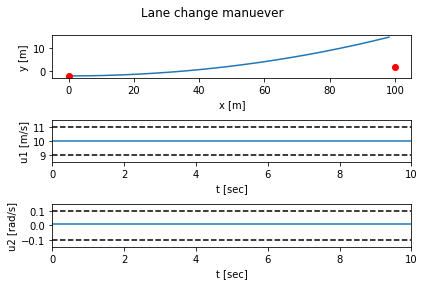

In [13]:
# Plot the results
plt.subplot(3, 1, 1)
plt.plot(y[0], y[1])
plt.plot(x0[0], x0[1], 'ro', xf[0], xf[1], 'ro')
plt.xlabel("x [m]")
plt.ylabel("y [m]")

plt.subplot(3, 1, 2)
plt.plot(t, u[0])
plt.axis([0, 10, 8.5, 11.5])
plt.plot([0, 10], [9, 9], 'k--', [0, 10], [11, 11], 'k--')
plt.xlabel("t [sec]")
plt.ylabel("u1 [m/s]")

plt.subplot(3, 1, 3)
plt.plot(t, u[1])
plt.axis([0, 10, -0.15, 0.15])
plt.plot([0, 10], [-0.1, -0.1], 'k--', [0, 10], [0.1, 0.1], 'k--')
plt.xlabel("t [sec]")
plt.ylabel("u2 [rad/s]")

plt.suptitle("Lane change manuever")
plt.tight_layout()
plt.savefig('example.jpg')
plt.show()